## <center>CSE 546: Reinforcement Learning</center>
### <center>Prof. Alina Vereshchaka</center>
<!-- ### <center>Fall 2022</center> -->

Welcome to the Assignment 2, Part 2

In [1]:
# Imports
from environment import WumpusWorldEnvironment
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import gym
from gym import RewardWrapper
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import random
import math
import torch
import pickle
import time
from IPython.display import display, clear_output
from datetime import datetime

##Part II [50 points] - Implementing DQN & Solving Various Problems

Source - https://arxiv.org/pdf/1312.5602\

In [ ]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define DQN Neural Network
class DQN(nn.Module):
    def __init__(self, input_dimensions, output_dimensions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dimensions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Memory
class Replay:
    def __init__(self, capacityN):
        self.tracker = deque(maxlen=capacityN)

    def push(self, s, a, r, s_, mission_accomplished):
        transition = (s, a, r, s_, mission_accomplished)
        self.tracker.append(transition)

    def sample(self, batch_len):
        transitions = random.sample(self.tracker, batch_len)
        batch = list(zip(*transitions))
        return (np.vstack(batch[0]), np.array(batch[1]), np.array(batch[2], dtype=np.float32),
                np.vstack(batch[3]), np.array(batch[4], dtype=np.uint8))

In [4]:
class DeterministicWarehouseRobotEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self):
        self.grid_size = 6 #6x6 grid
        self.start = [0, 0]
        self.pickup = [3, 3]
        self.end = [5, 5] # drop off location4
        self.agent_position = self.start.copy()
        self.obstacles = [(1, 3), (4, 2), (3,5),(4, 4)]
        self.picked_up_or_not = False
        self.actions = ["up", "down", "left", "right", "pick-up", "drop-off"]  # Up, Down, Left, Right, Pick-up, Drop-off
        self.observation_space = spaces.Dict({
            'agent_position': spaces.Tuple((spaces.Discrete(6), spaces.Discrete(6))), #coordinates could be any number between 0-5
            'agent_picked_up_or_not': spaces.Discrete(2) # 0 = not picked and 1 = picked
        })
        # Rewards
        self.reward_for_delivery = 100
        self.reward_pickup = 25
        self.reward_step = -1
        self.obstacle_penalty = -20
        self.invalid_Pickup_pentalty = -5
        self.invalid_Dropoff_pentalty = -5
        #self.q_table = {} not needed for part 1 checkpoint

    def reset(self):
        self.agent_position = self.start.copy()
        self.picked_up_or_not = False
        observation = {
            'agent_position': tuple(self.agent_position),
            'agent_picked_up_or_not': self.picked_up_or_not
        }
        return observation, {}

    def step(self, action):
      reward = self.reward_step
      mission_accomplished = False
      new_position = self.agent_position.copy()
      #actions
      if action == "up":  # Up
          new_position[0] -= 1
      elif action == "down":  # Down
          new_position[0] += 1
      elif action == "left":  # Left
          new_position[1] -= 1
      elif action == "right":  # Right
          new_position[1] += 1
      elif action == "pick-up":  # Pick-up
          if tuple(self.agent_position) == tuple(self.pickup) and not self.picked_up_or_not:
              self.picked_up_or_not = True
              reward += self.reward_pickup
          else:
              reward += self.invalid_Pickup_pentalty
      elif action == "drop-off":  # Drop-off
          if tuple(self.agent_position) == tuple(self.end) and self.picked_up_or_not:
              self.picked_up_or_not = False
              reward += self.reward_for_delivery
              mission_accomplished = True
          else:
              reward += self.invalid_Dropoff_pentalty
      # Check for collisions with obstacles or boundaries
      if tuple(new_position) in self.obstacles:
          reward += self.obstacle_penalty
      elif not (0 <= new_position[0] < 6 and 0 <= new_position[1] < 6):
          reward += self.obstacle_penalty
      else:
          self.agent_position = new_position
      # Observation
      observation = {
          'agent_position': tuple(self.agent_position),
          'agent_picked_up_or_not': self.picked_up_or_not
      }
      return observation, reward, mission_accomplished, False, {}

    def render(self):
      grid = np.zeros((6, 6))
      for obstacle in self.obstacles:
          grid[obstacle] = -1
      if not self.picked_up_or_not:
          grid[tuple(self.agent_position)] = 1
      else:
          grid[tuple(self.agent_position)] = 2
      grid[self.pickup[0], self.pickup[1]] = 3
      grid[self.end[0], self.end[1]] = 4
      plt.imshow(grid)
      plt.title('Warehouse Robot Environment')
      plt.show()

Episode 1, Total Reward: -6263, Epsilon: 0.98
Episode 2, Total Reward: -13569, Epsilon: 0.96
Episode 3, Total Reward: -6552, Epsilon: 0.94
Episode 4, Total Reward: -1610, Epsilon: 0.92
Episode 5, Total Reward: -426, Epsilon: 0.90
Episode 6, Total Reward: -6197, Epsilon: 0.89
Episode 7, Total Reward: -3243, Epsilon: 0.87
Episode 8, Total Reward: -180, Epsilon: 0.85
Episode 9, Total Reward: -4037, Epsilon: 0.83
Episode 10, Total Reward: -1179, Epsilon: 0.82
Episode 11, Total Reward: -8318, Epsilon: 0.80
Episode 12, Total Reward: -64, Epsilon: 0.78
Episode 13, Total Reward: -147, Epsilon: 0.77
Episode 14, Total Reward: -253, Epsilon: 0.75
Episode 15, Total Reward: -1017, Epsilon: 0.74
Episode 16, Total Reward: -64, Epsilon: 0.72
Episode 17, Total Reward: -216, Epsilon: 0.71
Episode 18, Total Reward: 18, Epsilon: 0.70
Episode 19, Total Reward: -148, Epsilon: 0.68
Episode 20, Total Reward: -189, Epsilon: 0.67
Episode 21, Total Reward: -18, Epsilon: 0.65
Episode 22, Total Reward: -24, Epsilo

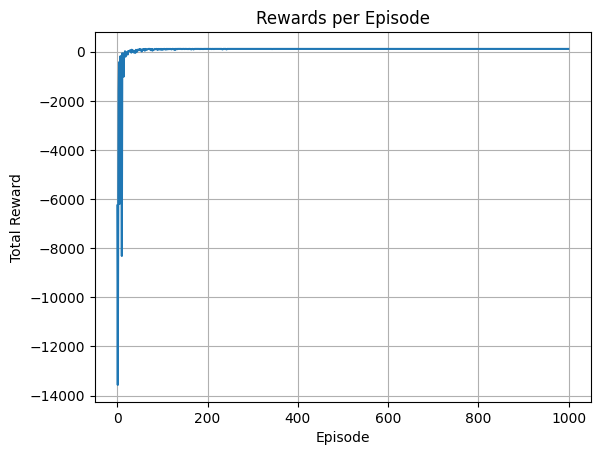

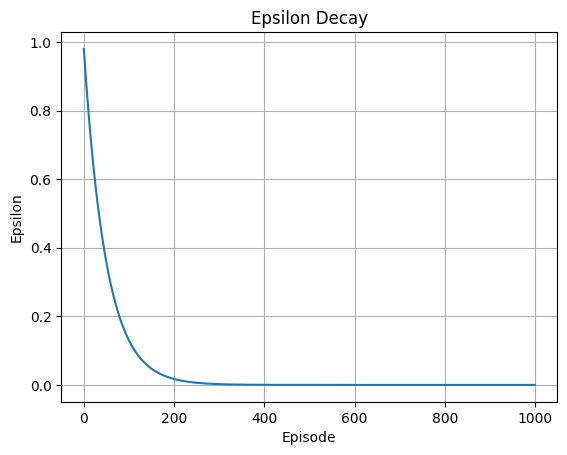

Model saved as DQN_2025-04-02_20-37.pickle


In [ ]:
BATCH_SIZE = 128
GAMMA = 0.75
EPS_START = 1.0
EPS_END = 0.00
EPS_DECAY = 0.98
TARGET_UPDATE = 2
LEARNING_RATE = 0.015
MEMORY_CAPACITY = 100000
NUM_EPISODES = 1000

# Initialize environment, DQN, and replay memory
env = DeterministicWarehouseRobotEnv()

input_dimensions = 3  # (x, y, picked_up_or_not)
output_dimensions = 6  # 6 actions: up, down, left, right, pick-up, drop-off

primary_net = DQN(input_dimensions, output_dimensions).to(device)
target_net = DQN(input_dimensions, output_dimensions).to(device)

target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(), lr=LEARNING_RATE)
memory = Replay(MEMORY_CAPACITY)

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 5)  # Random action
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        return primary_net(state_tensor).argmax().item()

def pickle_model(model, filename):
    with open(filename,'wb') as f:
        pickle.dump(model.state_dict(), f)

# Training step
def train_step():
    if len(memory.tracker) < BATCH_SIZE:
        return
    states, actions, rewards, states_, missions_accomplished = memory.sample(BATCH_SIZE)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    states_ = torch.FloatTensor(states_).to(device)
    missions_accomplished = torch.FloatTensor(missions_accomplished).to(device)
    # Compute Q-values for current states
    Q_current = primary_net(states).gather(1, actions.unsqueeze(1))
    # Compute Q-values for next states using the target network
    Q_next = target_net(states_).max(1)[0].detach()
    Q_target = rewards + GAMMA * Q_next * missions_accomplished
    # Compute loss and update the primary network
    loss = F.mse_loss(Q_current, Q_target.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
epsilon = EPS_START
rewards_per_episode= []
epsilon_values = []

for episode in range(NUM_EPISODES):
    observation, _ = env.reset()
    state = np.array([*observation['agent_position'], observation['agent_picked_up_or_not']])  # Flatten state
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        observation_, reward, mission_accomplished, _, _ = env.step(env.actions[action])
        next_state = np.array([*observation_['agent_position'], observation_['agent_picked_up_or_not']])  # Flatten next state
        memory.push(state, action, reward, next_state, not mission_accomplished)
        state = next_state
        total_reward += reward
        if mission_accomplished:
            done = True
        train_step()
    # Decay epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_values.append(epsilon)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())
    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Plot rewards
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.grid()
plt.show()

# Pickle weights
timestamp = time.strftime("%Y-%m-%d_%H-%M")
filename = f"DQN_{timestamp}.pickle"
pickle_model(primary_net, filename)
print(f"Model saved as {filename}")

Evaluation Episode 1: Total Reward = 113
Evaluation Episode 2: Total Reward = 113
Evaluation Episode 3: Total Reward = 113
Evaluation Episode 4: Total Reward = 113
Evaluation Episode 5: Total Reward = 113
Evaluation Episode 6: Total Reward = 113
Evaluation Episode 7: Total Reward = 113
Evaluation Episode 8: Total Reward = 113
Evaluation Episode 9: Total Reward = 113
Evaluation Episode 10: Total Reward = 113
Evaluation Episode 11: Total Reward = 113
Evaluation Episode 12: Total Reward = 113
Evaluation Episode 13: Total Reward = 113
Evaluation Episode 14: Total Reward = 113
Evaluation Episode 15: Total Reward = 113
Evaluation Episode 16: Total Reward = 113
Evaluation Episode 17: Total Reward = 113
Evaluation Episode 18: Total Reward = 113
Evaluation Episode 19: Total Reward = 113
Evaluation Episode 20: Total Reward = 113
Evaluation Episode 21: Total Reward = 113
Evaluation Episode 22: Total Reward = 113
Evaluation Episode 23: Total Reward = 113
Evaluation Episode 24: Total Reward = 113
E

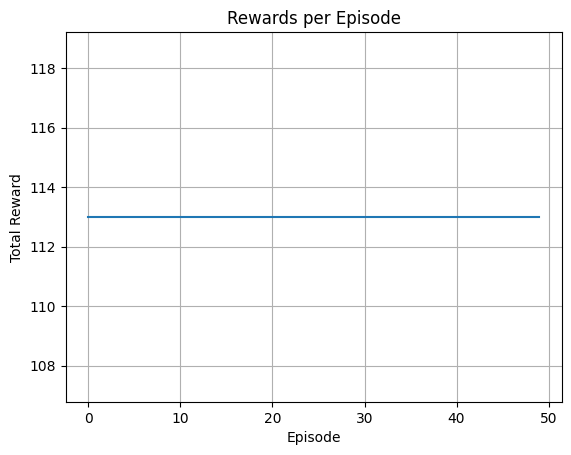

Average Evaluation Reward: 113.00


In [14]:
model_path = f"DQN_{timestamp}.pickle"
with open(model_path, 'rb') as f:
    model_weights = pickle.load(f)
primary_net.load_state_dict(model_weights)
primary_net.eval()

# Evaluation
EVAL_EPISODES = 50
rewards = []
for episode in range(EVAL_EPISODES):
    observation, _ = env.reset()
    state = np.array([*observation['agent_position'], observation['agent_picked_up_or_not']])
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = primary_net(state_tensor).argmax().item() # greedy actions only
        observation_, reward, mission_accomplished, _, _ = env.step(env.actions[action])
        next_state = np.array([*observation_['agent_position'], observation_['agent_picked_up_or_not']])
        state = next_state
        total_reward += reward
        if mission_accomplished:
            done = True
    rewards.append(total_reward)
    print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

# Plot the rewards per episode
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

average_eval_reward = sum(rewards) / EVAL_EPISODES
print(f"Average Evaluation Reward: {average_eval_reward:.2f}")

env.close()

Episode 1, Total Reward: 17.0, Epsilon: 1.00
Episode 2, Total Reward: 15.0, Epsilon: 1.00
Episode 3, Total Reward: 11.0, Epsilon: 0.99
Episode 4, Total Reward: 30.0, Epsilon: 0.99
Episode 5, Total Reward: 29.0, Epsilon: 0.99
Episode 6, Total Reward: 14.0, Epsilon: 0.99
Episode 7, Total Reward: 16.0, Epsilon: 0.98
Episode 8, Total Reward: 48.0, Epsilon: 0.98
Episode 9, Total Reward: 40.0, Epsilon: 0.98
Episode 10, Total Reward: 26.0, Epsilon: 0.98
Episode 11, Total Reward: 21.0, Epsilon: 0.97
Episode 12, Total Reward: 18.0, Epsilon: 0.97
Episode 13, Total Reward: 23.0, Epsilon: 0.97
Episode 14, Total Reward: 13.0, Epsilon: 0.97
Episode 15, Total Reward: 10.0, Epsilon: 0.96
Episode 16, Total Reward: 34.0, Epsilon: 0.96
Episode 17, Total Reward: 15.0, Epsilon: 0.96
Episode 18, Total Reward: 12.0, Epsilon: 0.96
Episode 19, Total Reward: 15.0, Epsilon: 0.95
Episode 20, Total Reward: 15.0, Epsilon: 0.95
Episode 21, Total Reward: 38.0, Epsilon: 0.95
Episode 22, Total Reward: 13.0, Epsilon: 0.

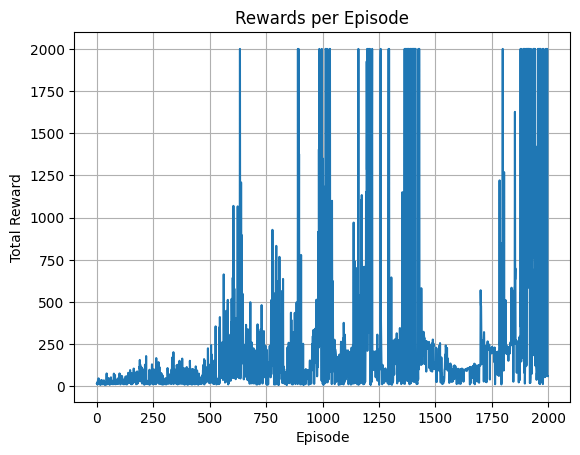

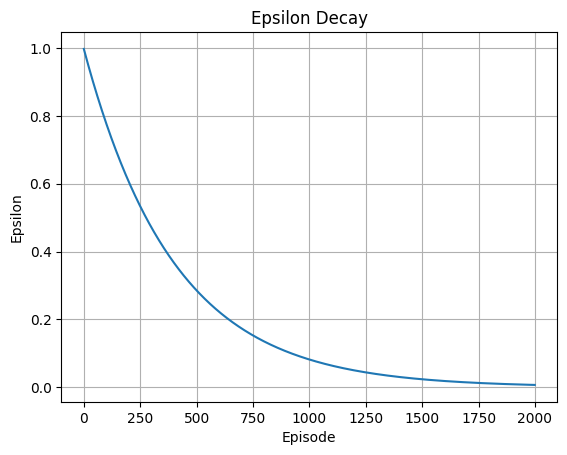

In [20]:
#parameters for 2.1 cartpole
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.00
EPS_DECAY = 0.9975
TARGET_UPDATE = 10
LEARNING_RATE = 0.001
MEMORY_CAPACITY = 10000
NUM_EPISODES = 2000
MAX_REWARD = 2000 # so it doesn't get 1.6 million reward when trained overnight and never finished >.<

# Define Replay Memory
class Replay:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, *transition):
        self.memory.append(transition)
    def sample(self, batch_size):
        batch = zip(*random.sample(self.memory, batch_size))
        result = []
        for x in batch:
            result.append(torch.tensor(np.array(x), dtype=torch.float32).to(device))
        return result
    
def pickle_model(model, filename):
    with open(filename,'wb') as f:
        pickle.dump(model.state_dict(), f)

# Initialize environment, DQN, and replay memory
env = gym.make("CartPole-v1")
input_dimensions = env.observation_space.shape[0]
output_dimensions = env.action_space.n
primary_net = DQN(input_dimensions, output_dimensions).to(device)
target_net = DQN(input_dimensions, output_dimensions).to(device)
target_net.load_state_dict(primary_net.state_dict())
optimizer = optim.Adam(primary_net.parameters(), lr=LEARNING_RATE)
memory = Replay(MEMORY_CAPACITY)

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
    return primary_net(state_tensor).argmax().item()

# Training step
def train_step():
    if len(memory.memory) < BATCH_SIZE:
        return
    states, actions, rewards, states_, missions_accomplished = memory.sample(BATCH_SIZE)
    # Compute Q-values for current states
    Q_current = primary_net(states).gather(1, actions.long().unsqueeze(1)).squeeze(1)
    # Compute Q-values for next states using the target network
    Q_next = target_net(states_).max(1)[0].detach()
    Q_target = rewards + GAMMA * Q_next * (1 - missions_accomplished)
    # Compute loss and update the primary network
    loss = F.mse_loss(Q_current, Q_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

consecutive_max_rewards = 0

# Training loop
epsilon = EPS_START
rewards_per_episode, epsilon_values = [], []
for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        # Max reward cap so episodes don't go on forever
        total_reward += reward
        if total_reward >= MAX_REWARD:
            total_reward = MAX_REWARD
            done = True
        memory.push(state, action, reward, next_state, done)
        state = next_state
        train_step()
    # Decay epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_values.append(epsilon)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())
    rewards_per_episode.append(total_reward)
    if total_reward >= MAX_REWARD:
        consecutive_max_rewards += 1
    else:
        consecutive_max_rewards = 0
    if consecutive_max_rewards >= 5:
        print(f"Training stopped early at episode {episode + 1}, hit max reward {consecutive_max_rewards} times in a row.")
        break
    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
env.close()

# Verify average reward > 470
average_reward = sum(rewards_per_episode)/len(rewards_per_episode)
print(f"Average Reward: {average_reward:.2f}")

# Pickle weights
timestamp = time.strftime("%Y-%m-%d_%H-%M")
filename = f"DQN_CartPoleV1_{timestamp}.pickle"
pickle_model(primary_net, filename)
print(f"Model saved as {filename}")

# Plot rewards
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.grid()
plt.show()

Evaluation Episode 1: Total Reward = 1000000
Evaluation Episode 2: Total Reward = 1000000
Evaluation Episode 3: Total Reward = 70.0
Evaluation Episode 4: Total Reward = 1000000
Evaluation Episode 5: Total Reward = 1000000


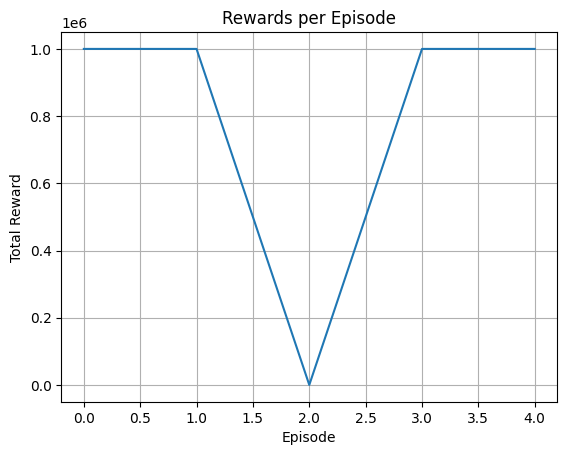

Average Evaluation Reward: 800014.00


In [31]:
model_path = f"DQN_CartPoleV1_{timestamp}.pickle"
with open(model_path, 'rb') as f:
    model_weights = pickle.load(f)
primary_net.load_state_dict(model_weights)
primary_net.eval()

# Evaluation
EVAL_EPISODES = 5
rewards_per_episode = []
for episode in range(EVAL_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        action = primary_net(state_tensor).argmax().item()  # greedy actions only
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if total_reward >= 1000000: # This is to prevent hours of evaluation
            total_reward = 1000000
            done = True
        state = next_state
    rewards_per_episode.append(total_reward)
    print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

# Plot the rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

average_eval_reward = sum(rewards_per_episode) / EVAL_EPISODES
print(f"Average Evaluation Reward: {average_eval_reward:.2f}")

env.close()

Episode 1, Total Reward: -200.42445616892263, Epsilon: 1.00, Status: Fail, Steps taken: 200
Episode 2, Total Reward: -199.12874546244223, Epsilon: 1.00, Status: Fail, Steps taken: 200
Episode 3, Total Reward: -199.84597643847863, Epsilon: 0.99, Status: Fail, Steps taken: 200
Episode 4, Total Reward: -199.92198707665955, Epsilon: 0.99, Status: Fail, Steps taken: 200
Episode 5, Total Reward: -199.79587028348973, Epsilon: 0.99, Status: Fail, Steps taken: 200
Episode 6, Total Reward: -198.980158342409, Epsilon: 0.99, Status: Fail, Steps taken: 200
Episode 7, Total Reward: -198.87998967053787, Epsilon: 0.99, Status: Fail, Steps taken: 200
Episode 8, Total Reward: -198.65564540259984, Epsilon: 0.98, Status: Fail, Steps taken: 200
Episode 9, Total Reward: -199.6821662710882, Epsilon: 0.98, Status: Fail, Steps taken: 200
Episode 10, Total Reward: -199.63164170182327, Epsilon: 0.98, Status: Fail, Steps taken: 200
Episode 11, Total Reward: -199.80312772177513, Epsilon: 0.98, Status: Fail, Steps 

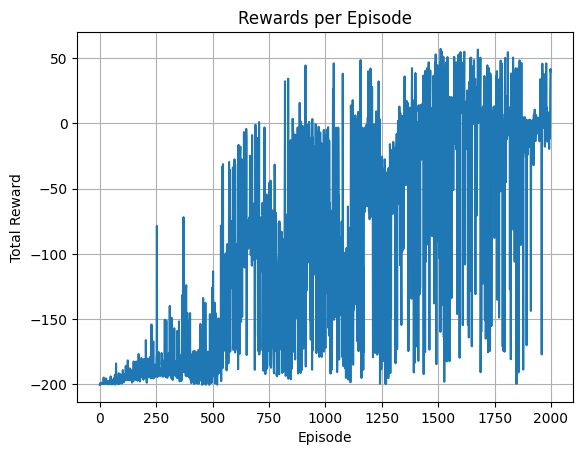

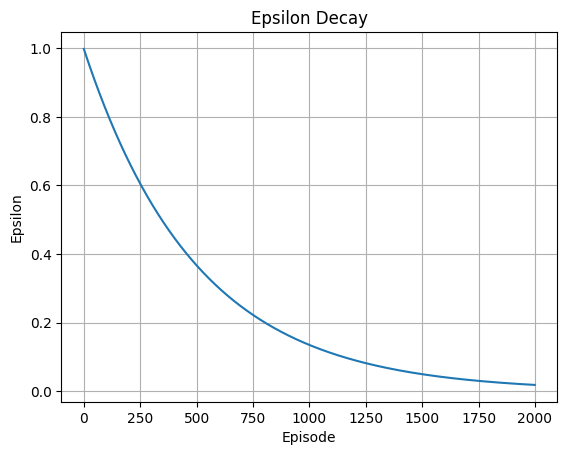

In [264]:
#parameters for 2.2 MountainCar-v0
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.00
EPS_DECAY = 0.998
TARGET_UPDATE = 10
LEARNING_RATE = 0.002
MEMORY_CAPACITY = 10000
NUM_EPISODES = 2000

# Initialize environment, DQN, and replay memory
env = gym.make("MountainCar-v0")
input_dimensions = env.observation_space.shape[0]
output_dimensions = env.action_space.n
primary_net = DQN(input_dimensions, output_dimensions).to(device)
target_net = DQN(input_dimensions, output_dimensions).to(device)
target_net.load_state_dict(primary_net.state_dict())
optimizer = optim.Adam(primary_net.parameters(), lr=LEARNING_RATE)
memory = Replay(MEMORY_CAPACITY)

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    st = torch.tensor(state, dtype=torch.float32).to(device)
    return primary_net(st).argmax().item()

# Training step
def train_step():
    if len(memory.memory) < BATCH_SIZE:
        return
    states, actions, rewards, states_, missions_accomplished = memory.sample(BATCH_SIZE)
    # Compute Q-values for current states
    Q_current = primary_net(states).gather(1, actions.long().unsqueeze(1)).squeeze(1)
    # Compute Q-values for next states using the target network
    Q_next = target_net(states_).max(1)[0].detach()
    Q_target = rewards + GAMMA * Q_next * (1 - missions_accomplished)
    # Compute loss and update the primary network
    loss = F.mse_loss(Q_current, Q_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
epsilon = EPS_START
rewards_per_episode, epsilon_values = [], []
for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0
    end = None
    while not done:
        action = select_action(state, epsilon)
        next_state, default_reward, done, _, _ = env.step(action)
        pos, vel = state
        next_pos, next_vel = next_state
        end = next_pos
        current_energy = 0.0025 * (math.sin(3*pos)+1.0) + 0.5*(vel**2)
        next_energy = 0.0025 * (math.sin(3*next_pos)+1.0) + 0.5*(next_vel**2)
        energy_gain = next_energy - current_energy
        custom_reward = 5000.0 * energy_gain
        if next_pos >= 0.5:
             custom_reward += (200-steps)
        reward = default_reward + custom_reward
        total_reward += reward
        memory.push(state, action, reward, next_state, done)
        state = next_state
        train_step()
        steps += 1
        if steps >= 200:
            #total_reward -= 100
            done = True
    # Decay epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_values.append(epsilon)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())
    rewards_per_episode.append(total_reward)
    status = "Success" if end is not None and end >= 0.5 else "Fail"
    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}, Status: {status}, Steps taken: {steps}")
env.close()

# Verify average reward
average_reward = sum(rewards_per_episode)/len(rewards_per_episode)
print(f"Average Reward: {average_reward:.2f}")

# Pickle weights
def pickle_model(model, filename):
    with open(filename,'wb') as f:
        pickle.dump(model.state_dict(), f)
timestamp = time.strftime("%Y-%m-%d_%H-%M")
filename = f"DQN_MountainCar-V0_{timestamp}.pickle"
pickle_model(primary_net, filename)
print(f"Model saved as {filename}")

# Plot rewards
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.grid()
plt.show()

Evaluation Episode 1: Total Reward = -89.0
Evaluation Episode 2: Total Reward = -106.0
Evaluation Episode 3: Total Reward = -110.0
Evaluation Episode 4: Total Reward = -99.0
Evaluation Episode 5: Total Reward = -111.0
Evaluation Episode 6: Total Reward = -104.0
Evaluation Episode 7: Total Reward = -177.0
Evaluation Episode 8: Total Reward = -89.0
Evaluation Episode 9: Total Reward = -97.0
Evaluation Episode 10: Total Reward = -111.0
Evaluation Episode 11: Total Reward = -98.0
Evaluation Episode 12: Total Reward = -87.0
Evaluation Episode 13: Total Reward = -88.0
Evaluation Episode 14: Total Reward = -92.0
Evaluation Episode 15: Total Reward = -111.0
Evaluation Episode 16: Total Reward = -111.0
Evaluation Episode 17: Total Reward = -89.0
Evaluation Episode 18: Total Reward = -109.0
Evaluation Episode 19: Total Reward = -89.0
Evaluation Episode 20: Total Reward = -106.0
Evaluation Episode 21: Total Reward = -110.0
Evaluation Episode 22: Total Reward = -89.0
Evaluation Episode 23: Total R

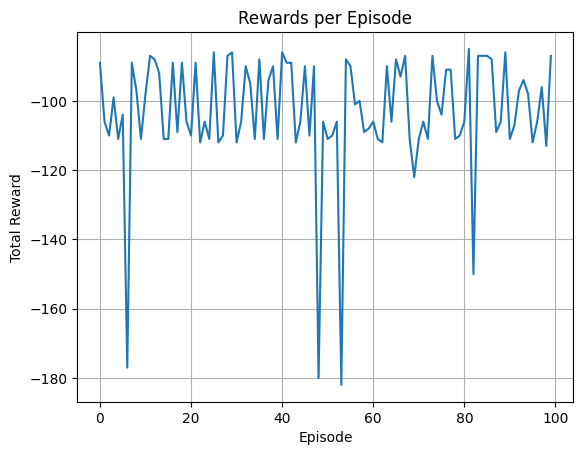

Average Evaluation Reward: -103.13


In [ ]:
model_path = f"DQN_MountainCar-V0_{timestamp}.pickle"
with open(model_path, 'rb') as f:
    model_weights = pickle.load(f)
primary_net.load_state_dict(model_weights)
primary_net.eval()

# Evaluation
EVAL_EPISODES = 100
rewards_per_episode = []
for episode in range(EVAL_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        action = primary_net(state_tensor).argmax().item()  # greedy actions only
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = next_state
    rewards_per_episode.append(total_reward)
    print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

# Plot the rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

average_eval_reward = sum(rewards_per_episode) / EVAL_EPISODES
print(f"Average Evaluation Reward: {average_eval_reward:.2f}")

env.close()